In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib

#xlrd.xlsx.ensure_elementtree_imported(False, None)
#xlrd.xlsx.Element_has_iter = True
#os.getcwd()
#os.chdir("..")
#os.chdir("..")

import sys
sys.path.append(r"C:\Users\Akshi\OneDrive\Documents\MSC\ODYM-master\odym\modules")

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')


INFO (2528825118.py <<module>>): ### 1. - Initialize.


In [2]:
# Use raw string (r"...") or double backslashes to avoid escape character issues
# Define the file path (using a raw string to avoid escape character issues)
file_path = r"C:\Users\Akshi\OneDrive\Documents\MSC\ODYM-master\data\PC_Vehicles-in-use.xlsx"

# If you know the sheet name (e.g., 'VPC'), use:
vpc = pd.read_excel(file_path, sheet_name ='VPC')

# Preview the data
print(vpc.head())

# Drop any rows where 'Year' or 'Vehicles' is missing
vpc.dropna(subset=['Year', 'Vehicles'], inplace=True)

# Convert year to integer (just in case it's float or string)
vpc['Year'] = vpc['Year'].astype(int)

vpc.head()

print(vpc['Year'].min(), vpc['Year'].max())   # Should print 1990 and 2024 (or later)

   Year  Vehicles
0  1950  2.802497
1  1951  2.855646
2  1952  2.909221
3  1953  3.006530
4  1954  3.055588
1950 2024


In [3]:
#Fitting the function

In [4]:
print(vpc.empty)

False


In [5]:
print(vpc['Year'].head())

0    1950
1    1951
2    1952
3    1953
4    1954
Name: Year, dtype: int32


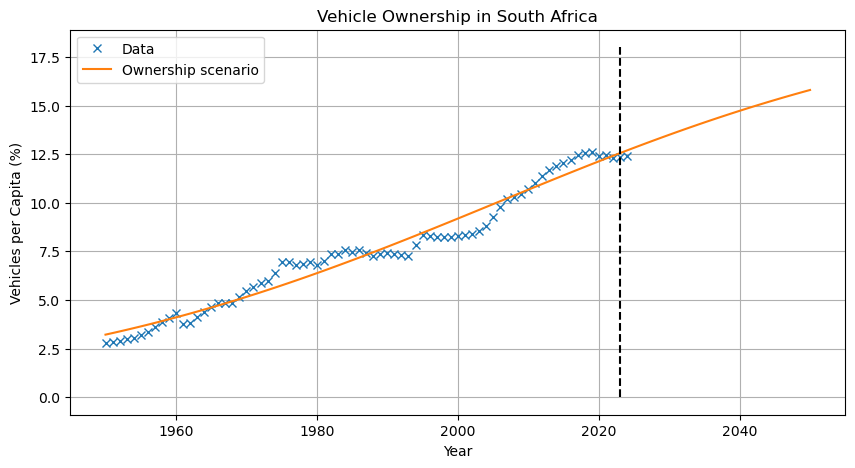

In [218]:
# Define logistic function
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Step 1: Load your VPC data
file_path = r"C:\Users\Akshi\OneDrive\Documents\MSC\ODYM-master\data\PC_Vehicles-in-use.xlsx"
vpc = pd.read_excel(file_path, sheet_name='VPC')  

# Step 2: Clean the data
vpc.dropna(subset=['Year', 'Vehicles'], inplace=True)
vpc['Year'] = vpc['Year'].astype(int)

# Step 3: Define the logistic function
def logistic(x, ti, tau, C0, C1):
    return (C1 - C0) / (1 + np.exp(-(x - ti) / tau)) + C0

# Step 4: Set time range and storage
t = np.arange(1950, 2051)
Nz = 1
Nt = len(t)
vpc_fit = np.zeros((Nz, Nt))

# Step 5: Fit the curve with reasonable bounds for smoother transition
popt, pcov = curve_fit(
    logistic,
    vpc['Year'].values,
    vpc['Vehicles'].values,
    bounds=(
        [1950,0, 0, 1],   # Lower: allow early rise + match your start
        [2050, 40, 10, 20]   # Upper: don't overshoot
   )
)
        
# Step 6: Apply the fitted curve
vpc_fit[0, :] = logistic(t, *popt)

# Step 7: Plot
plt.figure(figsize=(10, 5))
plt.plot(vpc['Year'], vpc['Vehicles'], 'x', label='Data')
plt.plot(t, vpc_fit[0], '-', label='Ownership scenario')
plt4, = plt.plot([2023,2023],[0,18], color = 'k', linestyle = '--')
plt.xlabel('Year')
plt.ylabel('Vehicles per Capita (%)')
plt.title('Vehicle Ownership in South Africa')
plt.legend(loc = 2)
plt.grid(True)
plt.show()


In [219]:
# Step 8: Print parameters
print("Fitted parameters [ti, tau, C0, C1]:", popt)

from sklearn.metrics import r2_score

# Predict values using your fitted model
y_pred = logistic(vpc['Year'].values, *popt)

# Calculate R²
r_squared = r2_score(vpc['Vehicles'].values, y_pred)

print(f"R² = {r_squared:.4f}")


Fitted parameters [ti, tau, C0, C1]: [2.00547840e+03 3.35957254e+01 5.70337589e-15 2.00000000e+01]
R² = 0.9658


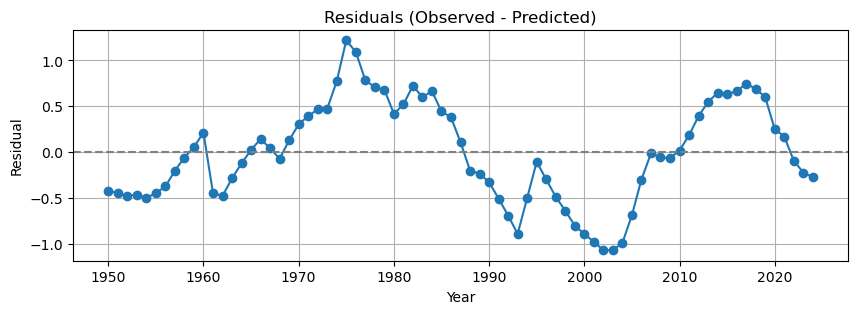

In [222]:
residuals = vpc['Vehicles'].values - y_pred
plt.figure(figsize=(10, 3))
plt.plot(vpc['Year'].values, residuals, 'o-')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Residuals (Observed - Predicted)')
plt.xlabel('Year')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

In [226]:
import pandas as pd

# Step 1: Load your VPC projection DataFrame
vpc_projection = pd.DataFrame({
    'Year': range(1950, 2051),
    'Vehicles_per_Capita': vpc_fit[0]  # Use the array from your logistic model
})

# Step 2: Define the full path to your existing Excel workbook
file_path = r"C:\Users\Akshi\OneDrive\Documents\MSC\ODYM-master\odym\modules\MSC_DMFA_StockDriven_SouthAfricaCarFleetData.xlsx"

# Step 3: Export the DataFrame to the 'VPC' sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    vpc_projection.to_excel(writer, sheet_name='VPC', index=False)
